In [1]:
%load_ext autoreload
%autoreload 2

In [193]:
#######
IN_DATA_FNAME = '/data/delon/LensQuEst/map_sims.pkl'
DATA_FNAME = '/data/delon/LensQuEst/QE_from_map_sims.pkl.bak'

import warnings
warnings.filterwarnings("ignore")
#####

In [4]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

#to get latex to work, shoulldn't be necessary for most ppl
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']

In [5]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr


In [6]:
print("Map properties")

# number of pixels for the flat map
nX = 400 # 1200
nY = 400 #1200

# map dimensions in degrees
sizeX = 10.
sizeY = 10.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [7]:
print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1., noise=1., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.ftotal(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

CMB experiment properties


In [8]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [9]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


In [10]:
#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

from scipy.ndimage import gaussian_filter 
from scipy.fft import fft2

mask = rgb2gray(plt.imread('mask_simple%dx%d.png'%(nX, nY)))
apodized_mask = gaussian_filter(mask, 3)
point_sources = rgb2gray(plt.imread('point_sources_bigger.png'))
point_sources = gaussian_filter(point_sources, 1.5) 
apodized_mask += point_sources
nPos = np.where(apodized_mask>1)
apodized_mask[nPos] = 1
mask = 1-mask
apodized_mask = 1 - apodized_mask

for a in apodized_mask:
    for b in a:
        assert(b<=1 and b>=0)
# plt.imshow(apodized_mask)

In [180]:
f = open(IN_DATA_FNAME, 'rb') 
in_data = pickle.load(f) 
f.close()
for key in in_data:
    print(key, np.shape(in_data[key]))

cmb0F_1 (400, 400, 201)
kCmbF_1 (400, 400, 201)
lCmbF_1 (400, 400, 201)
lCmbF_o1_1 (400, 400, 201)
lCmbF_o2_1 (400, 400, 201)
lCmbF_o3_1 (400, 400, 201)
lCmbF_o4_1 (400, 400, 201)
fgF_1 (400, 400, 201)
noiseF_1 (400, 400, 201)
totalF_1 (400, 400, 201)
totalF_M_1 (400, 400, 201)
totalF_0 (400, 400, 201)
totalF_M_0 (400, 400, 201)


In [181]:
pairs = [
    [0,0], #N0
    [0,1], #kappa
    [1,0], #kappa
    [1,1], #N1
    [0,2], #N1
    [2,0], #N1
    [-1, -1], #QE
    [-2, -2], #unlensed
]

data_names = {
    0: 'cmb0F_1',
    1: 'lCmbF_o1_1',
    2: 'lCmbF_o2_1',
    -1: 'lCmbF_1',
    -2: 'totalF_0',
}

In [194]:
f = open(DATA_FNAME, 'rb') 
data = pickle.load(f) 
f.close()
for key in data:
    print(key, np.shape(data[key]))

00 (400, 400, 201)
01 (400, 400, 201)
10 (400, 400, 201)
11 (400, 400, 201)
02 (400, 400, 201)
20 (400, 400, 201)
-1-1 (400, 400, 201)
-2-2 (400, 400, 201)


In [195]:
ps_data = {}

In [196]:
#estimate N0
ck = 'N0'

for data_idx in range(len(data['00'])):
    q00 = data['00'][data_idx]
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=q00)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [197]:
#estimate kk
ck = 'kk'


for data_idx in range(min(len(data['01']), len(data['10']))):
    q01 = data['01'][data_idx]
    q10 = data['10'][data_idx]
    kCmbFourier = in_data['kCmbF_1'][data_idx]
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.crossPowerSpectrum(dataFourier1=q10+q01, dataFourier2=kCmbFourier)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [198]:
#estimate N1
ck = 'N1'

for data_idx in range(min(len(data['00']), len(data['02']),len(data['20']),len(data['11']))):
    q02 = data['02'][data_idx]
    q20 = data['20'][data_idx]
    q00 = data['00'][data_idx]
    q11 = data['11'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.crossPowerSpectrum(dataFourier1=q00, 
                                                                                      dataFourier2=(q11+q02+q20))
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [ ]:
    q02 = data['02'][data_idx]
    q20 = data['20'][data_idx]
    q00 = data['00'][data_idx]
    q11 = data['11'][data_idx]

_,_,_ = baseMap.crossPowerSpectrum(dataFourier1=q00, dataFourier2=(q11+q02+q20), plot=True)

In [199]:
#estimate <QE QE>
ck = 'QEQE'
for data_idx in range(len(data['-1-1'])):
    QE = data['-1-1'][data_idx]
    
    c_ps_data = {}
    c_ps_data[ck] = [0,0,0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = baseMap.powerSpectrum(dataFourier=QE)
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([c_ps_data[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([c_ps_data[ck]]), ps_data[ck]))  

In [200]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
    sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    return lCen, Cls, sCls

def combine_sketchy(Cl0, Cli):
    n_runs = np.shape(Cl0)[0]
    print(n_runs, np.shape(Cl0))
    ret = np.copy(Cl0)
    ret = np.transpose(ret, axes=[1,2,0])
    ret[1] = np.array([
        [Cl0[run_idx][1][bin_idx]+
         sum([Cli[i][run_idx][1][bin_idx] for i in range(len(Cli))]) 
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    ret[2] = np.array([[np.sqrt(Cl0[run_idx][2][bin_idx]**2+sum([Cli[i][run_idx][2][bin_idx]**2 
                                                               for i in range(len(Cli))]))
                     for run_idx in range(n_runs)] 
                    for bin_idx in range(len(Cl0[0][1]))])
    return np.transpose(ret, axes=[2,0,1])

In [201]:
ps_data['N2+'] = combine_sketchy(ps_data['QEQE'], [-ps_data['N0'], -ps_data['kk'], -ps_data['N1']])

400 (400, 3, 50)


400 (400, 3, 50)
400 (400, 3, 50)
400 (400, 3, 50)
400 (400, 3, 50)
400 (400, 3, 50)
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.39178539e-08
  0.00000000e+00 -5.13752341e-08  0.00000000e+00 -4.01744190e-08
  0.00000000e+00 -3.12640549e-08 -2.58400902e-08 -2.48477686e-08
 -1.71473871e-08 -1.68455597e-08 -1.81491208e-08 -1.58260704e-08
 -1.48370245e-08 -1.39635563e-08 -1.46311323e-08 -1.39017180e-08
 -1.23643726e-08 -1.19285393e-08 -1.16959650e-08 -1.15605306e-08
 -1.21054740e-08 -1.38638673e-08 -1.73089333e-08  3.15160579e-09
  2.13991092e-08  1.21542794e-07  8.38930807e-07 -2.47459594e-03
  0.00000000e+00  0.00000000e+00]


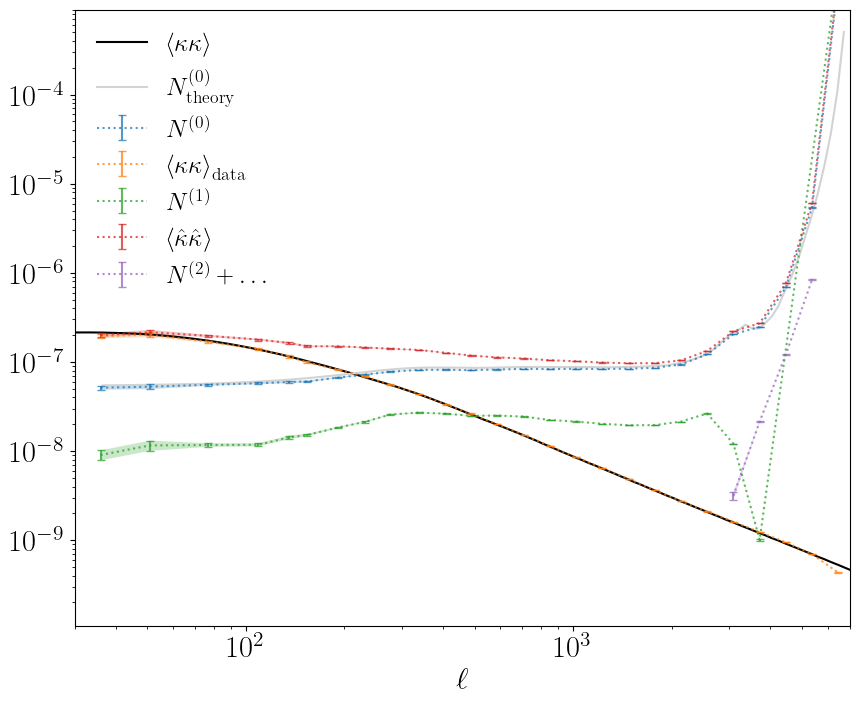

In [202]:
fig,ax = plt.subplots(nrows=1, figsize=(10,8))

ell = baseMap.l.flatten()
theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N^{(0)}_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    ax.plot(L, ClExpected, sty, label=l)

labels={
    'N0':r'$N^{(0)}$',
    'kk':r'$\left<\kappa\kappa\right>_{\rm data}$',
    'N1':r'$N^{(1)}$',
    'N2+':r'$N^{(2)}+\dots$',
    'QEQE':r'$\left<\hat\kappa\hat\kappa\right>$',

}
for key in ps_data:
    lCen, Cl, sCl = combine_Cl(np.array(ps_data[key]))
    if(key=='N2+'):
        print(Cl)
    Ipos = np.where(Cl>=1e-30)
    
    ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
                fmt=':', capsize=3, capthick=1, label=labels[key])
    tmp_data = {
        'x': lCen[Ipos],
        'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
        'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
    ax.fill_between(**tmp_data,  alpha=.25)


ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_yscale('log')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(1.1e-10,.9e-3)

plt.savefig('figures/Ni_decomposed.pdf', bbox_inches='tight')